<a href="https://colab.research.google.com/github/NsiriRoua/-AI-Powered-Sentiment-Analysis-Platform/blob/main/Arabert_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving arabizi_french_refined_labeled_dataset_filtred.csv to arabizi_french_refined_labeled_dataset_filtred.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
import pandas as pd

# Load the CSV file
#file_name = next(iter(uploaded))
file_name = "/content/drive/MyDrive/Thesis_tunisian/Thesis_tunisian/arabizi_french_refined_labeled_dataset_filtred.csv"
df = pd.read_csv(file_name)

# Display the first few rows of the dataframe
print(df.head())

                                               words              labels
0                ['non', 'ça', 'va', 'jawi', 'behi']     [1, 1, 1, 0, 0]
1            ['aaslema,', 'chnahwelek', 'ça', 'va?']  [-100, 0, 0, -100]
2  ['normalement', 'c’est', 'bon', 'kolchay', 'mr...  [1, -100, 1, 1, 0]
3                              ['merci', 'aaycheek']              [1, 0]
4             ['voilà', 'hateni', 'heke', 'chksadt']        [1, 0, 0, 0]


In [ ]:
import ast

# Convert string lists to actual lists
df["words"] = df["words"].apply(ast.literal_eval)
df["labels"] = df["labels"].apply(ast.literal_eval)

In [ ]:
df["words"] = df["words"].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)
df["labels"] = df["labels"].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

In [ ]:
# Check the first few rows of the dataset
print(df.head())

                                         words              labels
0                    [non, ça, va, jawi, behi]     [1, 1, 1, 0, 0]
1              [aaslema,, chnahwelek, ça, va?]  [-100, 0, 0, -100]
2  [normalement, c’est, bon, kolchay, mriguel]  [1, -100, 1, 1, 0]
3                            [merci, aaycheek]              [1, 0]
4               [voilà, hateni, heke, chksadt]        [1, 0, 0, 0]


In [ ]:
import numpy as np

all_labels = [label for sublist in df["labels"] for label in sublist if label != -100]
unique, counts = np.unique(all_labels, return_counts=True)
print(dict(zip(unique, counts)))

# Expected output (example):
# {0: 12000, 1: 8000}  # Adjust if imbalance > 60/40

{np.int64(0): np.int64(1136592), np.int64(1): np.int64(158015)}


In [ ]:
print(df.iloc[0]["words"])  # Should output: ['non', 'ça', 'va', 'jawi', 'behi']
print(df.iloc[0]["labels"])  # Should output: [1, 1, 1, 0, 0]

['non', 'ça', 'va', 'jawi', 'behi']
[1, 1, 1, 0, 0]


In [ ]:
from datasets import Dataset
from sklearn.model_selection import train_test_split
# Split the dataset into training and evaluation sets
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert the pandas dataframes to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

In [ ]:
from transformers import AutoTokenizer

model_name = "aubmindlab/bert-base-arabertv2"  # or any AraBERT model
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize_and_align_labels(examples):
    # Tokenize the words
    tokenized_inputs = tokenizer(
        examples["words"],
        truncation=True,  # Enable truncation
        padding="max_length",  # Pad to a fixed length
        max_length=128,  # Adjust max_length as needed
        is_split_into_words=True  # Indicate that the input is already split into words
    )

    # Align labels with tokenized input
    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Special tokens (CLS, SEP, PAD) get -100
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])  # New word
            else:
                label_ids.append(-100)  # Subword of the same word
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs
# Tokenize the datasets
tokenized_train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_and_align_labels, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/212376 [00:00<?, ? examples/s]

Map:   0%|          | 0/53095 [00:00<?, ? examples/s]

In [ ]:
# Check the length of the first few tokenized sequences
for i in range(3):
    print(len(tokenized_train_dataset[i]['input_ids']))

128
128
128


In [ ]:
print(tokenized_train_dataset[0])

{'words': ['arbi', 'mezni', 'abda3'], 'labels': [-100, 1, -100, -100, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100], '__index_level_0__': 155040, 'input_ids': [33, 30715, 229, 230, 30209, 282, 233, 230, 36629, 40017, 204, 34, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,

In [ ]:
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification
from peft import LoraConfig, get_peft_model


model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=3  # 3 classes: 0 (fr), 1 (ar), -100 (ignore)
)


lora_config = LoraConfig(
    r=8,                  # Rank of the low-rank matrices (smaller = less memory)
    lora_alpha=16,        # Scaling factor for LoRA weights
    target_modules=["query", "value"],  # Layers to apply LoRA to (attention layers)
    lora_dropout=0.1,
    bias="none",
    task_type="TOKEN_CLS",  # Adjust for your task
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # Check trainable params (should be small)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 297,219 || all params: 134,902,278 || trainable%: 0.2203


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored labels (-100)
    true_labels = [[l for l in label if l != -100] for label in labels]
    true_predictions = [
        [p for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Flatten lists
    true_labels = [item for sublist in true_labels for item in sublist]
    true_predictions = [item for sublist in true_predictions for item in sublist]

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average="binary")
    acc = accuracy_score(true_labels, true_predictions)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Thesis_tunisian/Thesis_tunisian/results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    save_total_limit=2,
    save_steps=500,
    logging_dir="/content/drive/MyDrive/Thesis_tunisian/Thesis_tunisian/logs",
    logging_steps=10,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import TrainingArguments
# TrainingArguments with optimizations
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Thesis_tunisian/Thesis_tunisian/results",
    fp16=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    learning_rate=2e-5,
    num_train_epochs=10,
    logging_dir="/content/drive/MyDrive/Thesis_tunisian/Thesis_tunisian/logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Initialize Trainer
from transformers import Trainer

data_collator = DataCollatorForTokenClassification(tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# Fine-tune the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nsiriroua99 (nsiriroua99-university-of-passau) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.279300,0.302145,0.892344,0.373116,0.658026,0.260379
2,0.312500,0.297969,0.893682,0.385831,0.667037,0.271411
3,0.316900,0.295976,0.894567,0.390734,0.676085,0.274765
4,0.296200,0.294753,0.895325,0.395406,0.683360,0.278185
5,0.282100,0.294044,0.895432,0.401009,0.679273,0.284475
6,0.290400,0.293605,0.895742,0.398048,0.687268,0.280152
7,0.271500,0.293319,0.895940,0.400210,0.688144,0.282152
8,0.283400,0.293008,0.895853,0.403907,0.682848,0.286765
9,0.300700,0.292900,0.895980,0.401808,0.687066,0.283926


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn

TrainOutput(global_step=132730, training_loss=0.30456367294152303, metrics={'train_runtime': 9129.0763, 'train_samples_per_second': 232.637, 'train_steps_per_second': 14.539, 'total_flos': 1.3920896859479654e+17, 'train_loss': 0.30456367294152303, 'epoch': 9.999284288243492})

In [ ]:

# Save only LoRA adapters (tiny files)
model.save_pretrained("/content/drive/MyDrive/Thesis_tunisian/Thesis_tunisian//lora_adapters")

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from peft import PeftModel

# Base model
model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=3)

# Load LoRA adapters
model = PeftModel.from_pretrained(base_model, "/content/drive/MyDrive/Thesis_tunisian/Thesis_tunisian/lora_adapters")
model.eval()  # Set to evaluation mode

Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForTokenClassification(
  (base_model): LoraModel(
    (model): BertForTokenClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(64000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Lin

In [ ]:
# Example input (Tunisian Arabizi/French code-switched text)
text = "slt cv? ana msh b1 nhar lyoum. normalement, c'est bon."
tokens = text.split()  # Simple whitespace tokenization (customize as needed)

In [ ]:
# Tokenize with the same settings as training
inputs = tokenizer(
    tokens,
    truncation=True,
    padding="max_length",
    max_length=128,
    is_split_into_words=True,  # Critical for alignment
    return_tensors="pt"
).to(model.device)  # Move to GPU if available

In [ ]:
import torch

with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

In [ ]:
# Map predictions to original tokens
word_ids = inputs.word_ids(batch_index=0)  # Get word indices for tokens
predictions = predictions[0]  # Remove batch dimension

# Filter out special tokens (-100)
filtered_predictions = []
for word_idx, pred in zip(word_ids, predictions):
    if word_idx is not None:  # Ignore [CLS], [SEP], padding
        filtered_predictions.append((tokens[word_idx], pred))

# Display results
for token, label in filtered_predictions:
    print(f"{token} -> {'FR' if label == 0 else 'AR'}")

slt -> FR
slt -> FR
slt -> FR
cv? -> FR
cv? -> FR
cv? -> FR
ana -> FR
ana -> FR
msh -> FR
msh -> FR
b1 -> FR
b1 -> FR
nhar -> FR
nhar -> FR
nhar -> FR
lyoum. -> FR
lyoum. -> FR
lyoum. -> FR
lyoum. -> FR
lyoum. -> FR
normalement, -> FR
normalement, -> FR
normalement, -> FR
normalement, -> FR
normalement, -> FR
c'est -> FR
c'est -> FR
c'est -> FR
bon. -> FR
bon. -> FR
bon. -> FR


In [ ]:
def colorize_token(token, label):
    colors = {"FR": "\033[94m", "AR": "\033[92m", "RESET": "\033[0m"}
    return f"{colors['FR' if label == 0 else 'AR']}{token}{colors['RESET']}"

colored_output = " ".join([colorize_token(tok, lbl) for tok, lbl in filtered_predictions])
print(colored_output)

slt slt slt cv? cv? cv? ana ana msh msh b1 b1 nhar nhar nhar lyoum. lyoum. lyoum. lyoum. lyoum. normalement, normalement, normalement, normalement, normalement, c'est c'est c'est bon. bon. bon.


<ipython-input-3-708a0cfb0e14>:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


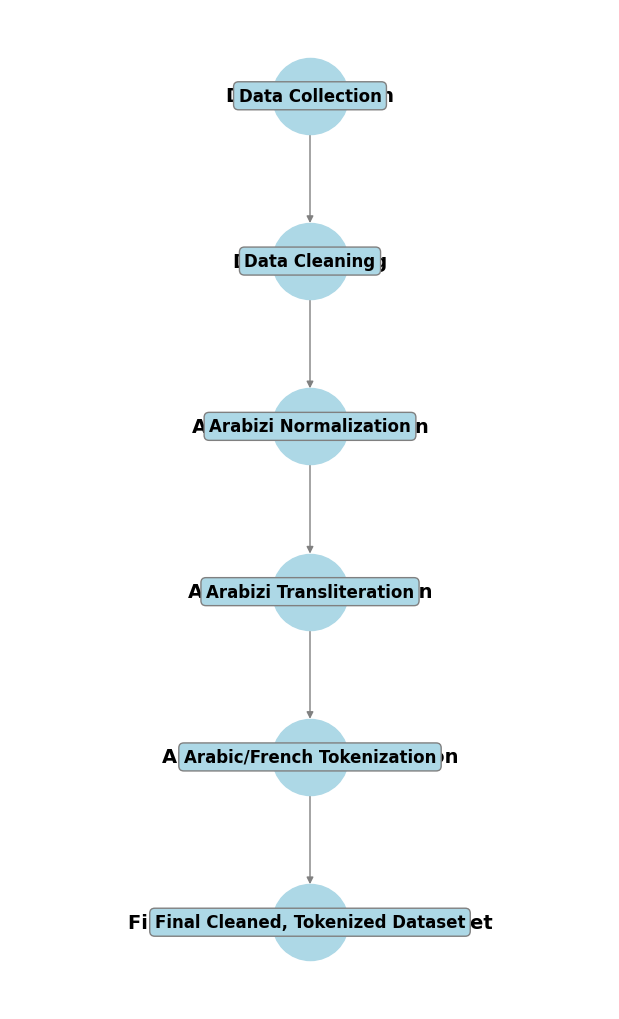

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph for the data preprocessing steps
G = nx.DiGraph()

# Add nodes for each preprocessing step
steps = ["Data Collection", "Data Cleaning", "Arabizi Normalization", "Arabizi Transliteration", "Arabic/French Tokenization", "Final Cleaned, Tokenized Dataset"]
G.add_nodes_from(steps)

# Add edges to connect the steps in order
edges = [("Data Collection", "Data Cleaning"),
         ("Data Cleaning", "Arabizi Normalization"),
         ("Arabizi Normalization", "Arabizi Transliteration"),
         ("Arabizi Transliteration", "Arabic/French Tokenization"),
         ("Arabic/French Tokenization", "Final Cleaned, Tokenized Dataset")]

G.add_edges_from(edges)

# Create a layout with a vertical flow (straight line)
pos = {steps[i]: [0, -i] for i in range(len(steps))}

# Draw the graph with boxes and arrows
plt.figure(figsize=(6, 10))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=14,
        edge_color='gray', arrows=True, font_color="black", font_weight='bold')

# Add a background box for each step
for node, (x, y) in pos.items():
    plt.text(x, y, node, ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(facecolor='lightblue', edgecolor='gray', boxstyle="round,pad=0.3"))

# Remove the axis
plt.axis('off')
plt.tight_layout()
plt.show()
